# Variational Inference for Calibration

Previously I've tried:

 - A full (HMC) MCMC model in which we model both the air pollution and the calibration using Gaussian processes for both. This failed, probably due to the excessive correlation in GPs which leads to poor mixing.
 
 - To aleviate this I tried two complementary approaches:
    1. I introduced a sparse approximation, so the HMC is sampling the posterior of just the inducing points, leading to a solution similar to [1].
    2. Whiten the inducing point values (originally I learnt of this trick with the help of people on the TFP [issue queue](https://github.com/tensorflow/probability/issues/551), but this is also in [1])
   
   These didn't work very well. The main issue I think is that the whitening only applies the known covariance in the prior, while much/most of the correlation structure is mediated through the likelihood. Consider the situation in which the model needs to really sample the calibration for one sensor at a higher value. This will lead to all the down-stream sensors' inducing points all needing to be increased. A massively strong correlation structure that is hard for the HMC sampler to explore.
   
 - Instead I tried a standard VI approach with the inducing point values modelled with a multivariate Gaussian. This failed to properly span the full range of uncertainty. I think this is probably due to the very non-Gaussian nature of the strong correlated domain between the latent pollution and the calibration (conditioned on an observation). I explored different likelihood functions, but the problem remained.
 
Finally I realised that I needed to approach the likelihood in a different way: Rather than model the pollution as a separate process, I just modelled calibration. The likelihood of pairs of observations (from colocated pairs of sensors) is computed directly.

This I found still didn't work for the HMC/MCMC solution. I suspect that this is due to the strong correlations that still exist between the calibration of one sensor and another (via the likelihood and observations). However, VI with a fairly standard multivariate Gaussian approximating distribution fares much better. The correlation (through the likelihood) probably still remains fairly Gaussian and VI doesn't mind the correlations that seem to cause HMC some trouble.

We compute the log likelihood by sampling from a 2d distribution of the scaling processes for the two sensors involved in the colocation observation. A few obvious likelihood functions present themselves. The most obvious is to take the two scalings, multiply them by the observations and use the difference in the two scale-observations in a (mean-zero) normal distribution. Alternatively the ratio of the two (fed into a mean-one normal distribution.
The 2d normal distribution mentioned above, of the two sensors is computed at the observation time by standard sparse, inducing point regression, with the variational approximation for the inducing point values.

What's the downside of using this formulation rather than the full model with calibration and pollution processes? The downside is that observation pairs that aren't from the same time and location (which are likely still to be correlated) can't be used directly in this. While before, with a latent pollution function mediating the connection it was possible to calibrate using these pairs of observations (while still accounting for the resulting increased uncertainty). In practice it is likely, at the start, that one will only wish to use co-location for calibration anyway, as there would be far more assumptions (lengthscales etc) that would be required for the more advanced calibration-at-a-distance. In future one might simply estimate the additional variance (rather than say try to include the shift in mean) as a compromise.

In the example here, we use a simple pathway through five sensors (the first is a reference). The second and fourth are mobile. See figure below for further details of this demo.
    
[1] Hensman, James, et al. "MCMC for variationally sparse Gaussian processes." Advances in Neural Information Processing Systems. 2015. 
 

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels
import pandas as pd
import numpy as np
from tensorflow_probability import distributions as tfd
import time
np.set_printoptions(precision=3,suppress=True)

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Building Synthetic Dataset
Inputs: 
 - `X` is a $(2N)\times 2$ matrix. Each pair of sensors for the calibration are in the top and bottom half of `X`. The first column is time, the second column is sensor.
 - `Y` is an $N \times 2$ matrix. Each pair of sensor values are next to each other.
 - `Z` is an $M \times 2$ matrix. First column time, second column sensor.

To build this we first make a 'raw' set of Xs and Ys that are:
 - `rawX` is a matrix with columns: time, place sensor.
 - `rawY` are the measurements of the sensors

In [2]:
def gettruepol(x,l):
    return 80+10*np.sin((x)/10)*(1+np.cos(x/5)+5*np.cos(l))

def getsensorscaling(x,s):
    return (1+(0.1+0.2*np.cos(x/20+s))+(0.3*np.sin(s))/5)*(1-(s==0))+(s==0)

sensorconfig = [[(-np.inf,0)],[(-np.inf,0),(20,1)],[(-np.inf,1)],[(-np.inf,1),(20,2)],[(-np.inf,2)]]
N = 50
rawX = np.zeros([0,3])
for i,sconf in enumerate(sensorconfig):
    x = np.sort(np.random.rand(N)*50).astype(np.float32)[:,None]
    locs = np.zeros_like(x)
    for t,l in sconf:
        locs[x>t]=l
    rawX = np.r_[rawX,(np.c_[x,locs,np.full_like(x,i)])]
rawY = gettruepol(rawX[:,0],rawX[:,1])[:,None]*getsensorscaling(rawX[:,0],rawX[:,2])[:,None]

The five sensors are each scaled different and have their scaling change over the experimental period to simulate sensor drift.

Text(0, 0.5, 'Scaling')

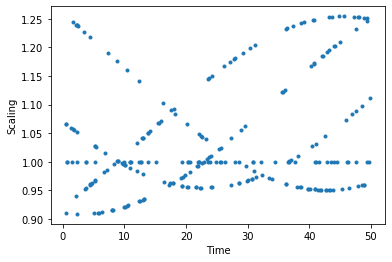

In [61]:
plt.plot(rawX[:,0],getsensorscaling(rawX[:,0],rawX[:,2]),'.')
plt.xlabel('Time')
plt.ylabel('Scaling')

In [4]:
t = 1
L = 3
S = 5
Xa = []
Xb = []
Y = []
for t in range(80):
    for l in range(L):
        keep = (np.abs(rawX[:,0]-t)<0.5) & (rawX[:,1]==l)
        #print(rawX[keep,:])
        sensors = np.unique(rawX[keep,2])
        if len(sensors)>1:
            #TODO: Don't yet handle when there are more than 2 sensors
            #for s in sensors: 
            #print("s:%d" % s)
            #print(np.mean(rawX[keep & (rawX[:,2]==s),0]),np.mean(rawY[keep & (rawX[:,2]==s)]))
            Xa.append([t,sensors[0]])
            Xb.append([t,sensors[1]])
            Y.append([np.mean(rawY[keep & (rawX[:,2]==sensors[0])]),np.mean(rawY[keep & (rawX[:,2]==sensors[1])])])
X = np.array(Xa+Xb).astype(int)
Y = np.array(Y)
S = int(max(rawX[:,2])+1)
L = int(max(rawX[:,1])+1)
N = len(Xa)

This figure illustrates the colocation events. The y-axis indicates the five sensors (0,1,2,3,4). Vertical lines indicate when observations in two sensors have happened at the same time and place. For the first part of the experiment, mobile sensor 1 is colocated with the reference sensor, then visits sensors 2. Similarly another mobile sensor (3) visits sensor 2 for a while before visiting sensor 4. The upshot is that the calibration from the reference sensor (0) has to pass through the chain of sensors.

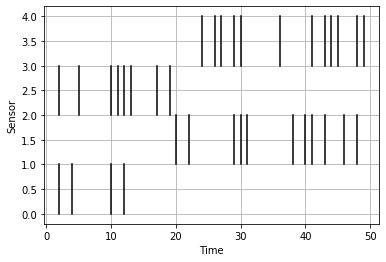

In [58]:
for x1,x2 in zip(X[:N,:],X[N:,:]):
    plt.plot([x1[0],x2[0]],[x1[1],x2[1]],'-k')
plt.ylabel('Sensor')
plt.xlabel('Time')
plt.grid()

In [59]:
#set up inducing point locations - evenly spaced
M = 8
Z = np.linspace(0,50,M)[None,:]
Z = np.repeat(Z,S,0)
Z = Z.flatten()[:,None]
Z = np.c_[Z,np.repeat(np.arange(S),M)]

In [42]:
class Kernel():
    def k(self,x1,x2):
        return 2.0**2*np.exp(-(x1-x2)**2/(2*80.0**2))+4
    
    def matrix(self,X1,X2):
        try:
            X1 = X1.numpy()
            X2 = X2.numpy()
        except AttributeError:
            pass
        r = np.zeros([X1.shape[0],X2.shape[0]])
        for i1,x1 in enumerate(X1):
            for i2,x2 in enumerate(X2):
                    if x1[1]==x2[1]: #if same sensor
                        r[i1,i2] = self.k(x1[0],x2[0])
        return tf.Variable(r,dtype=tf.float32)


In [43]:
#definition of q(u)
m = Z.shape[0]
mu = tf.Variable(0.01*tf.random.normal([m,1]))
scale = tf.Variable(1*np.tril(0.1*np.random.randn(m, m)+np.eye(m)),dtype=tf.float32)

k = Kernel()

#parameters for p(u)
mu_u = tf.zeros([m],dtype=tf.float32)
cov_u = tf.Variable(k.matrix(Z,Z),dtype=tf.float32)

jitter = 1e-4
pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*jitter)
Kzz = k.matrix(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*jitter
Kxx = k.matrix(X,X)+np.eye(X.shape[0],dtype=np.float32)*jitter
Kxz = k.matrix(X,Z)
Kzx = tf.transpose(Kxz)
KzzinvKzx = tf.linalg.solve(Kzz,Kzx)
KxzKzzinv = tf.transpose(KzzinvKzx)
KxzKzzinvKzx = Kxz @ KzzinvKzx
N = int(X.shape[0]/2)

In [44]:
def getcov(scale):
    return tf.linalg.band_part(scale, -1, 0) @ tf.transpose(tf.linalg.band_part(scale, -1, 0))

In [45]:
refsensor = np.array([1,0,0,0,0]).astype(np.float32)

In [46]:
ref = tf.gather(refsensor,tf.transpose(tf.reshape(X[:,1:2],[2,N])))


In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,amsgrad=False)

In [50]:
starttime = time.time()

for it in range(5000):

    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu[:,0],scale)
        
        qf_mu = KxzKzzinv @ mu
        qf_cov = Kxx - KxzKzzinvKzx + KxzKzzinv @ getcov(scale) @ KzzinvKzx
        batched_mu = tf.transpose(tf.reshape(qf_mu,[2,N]))
        batched_cov = [[tf.linalg.diag_part(qf_cov[:N,:N]),tf.linalg.diag_part(qf_cov[N:,:N])],[tf.linalg.diag_part(qf_cov[:N,N:]),tf.linalg.diag_part(qf_cov[N:,N:])]]
        samps = tfd.MultivariateNormalFullCovariance(batched_mu,tf.transpose(batched_cov)+tf.eye(2)*jitter).sample(1000)
        scaled = ((tf.exp(samps) * Y) * (1-ref)) + (Y * ref)  #(tf.exp(samps) * Y)
        #ell = tf.reduce_mean(tf.reduce_sum(tfd.Normal(0,1.0).log_prob(scaled[:,:,0]-scaled[:,:,1]),1))
        ell = tf.reduce_mean(tf.reduce_sum(tfd.Normal(1.0,0.01).log_prob(scaled[:,:,0]/scaled[:,:,1]),1))
        elbo_loss = -ell+tfd.kl_divergence(qu,pu)
        gradients = tape.gradient(elbo_loss, [mu,scale])
        optimizer.apply_gradients(zip(gradients, [mu, scale]))

    if it%50==0: 
        print("%4d %0.1f %8.0f %8.0f %8d" % (it,elbo_loss.numpy(),gradients[0].numpy()[0,0],gradients[1].numpy()[0,0],int(time.time()-starttime)))
        #print(mu.numpy()[::10].T)

   0 1778.7       -0        7        0
  50 49.2       -1       -1        1
 100 18.1       -0       -0        3
 150 14.8        0       -0        4
 200 13.4        0       -0        6
 250 12.1        0       -0        7
 300 11.6        0       -0        9
 350 11.0        0       -0       10
 400 10.4        0        0       12
 450 10.3        0       -0       14
 500 12.2        0       -0       15
 550 10.2        0       -0       17
 600 10.6        0       -0       18
 650 10.9        0       -0       20
 700 8.9        0       -0       22
 750 10.3       -3       -1       23
 800 10.1        0       -0       25
 850 9.9       -0       -0       26
 900 9.8        0       -4       28
 950 10.1        0        0       29
1000 9.2        0        0       31
1050 10.4        1       -0       33
1100 10.3        0       -2       34
1150 10.0       -0        0       36
1200 9.9       -0       -0       38
1250 10.2        2        7       40
1300 9.8        0        0       41
1350 

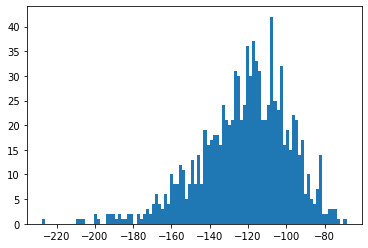

In [51]:
#plt.hist(tfd.Normal(0,1.0).log_prob(scaled[:,:,0]-scaled[:,:,1]).numpy().flatten(),100);
plt.hist(tf.reduce_sum(tfd.Normal(0,1.0).log_prob(scaled[:,:,0]-scaled[:,:,1]),1),100);

In [52]:
ell,tfd.kl_divergence(qu,pu)

(<tf.Tensor: shape=(), dtype=float32, numpy=33.35552>,
 <tf.Tensor: shape=(), dtype=float32, numpy=42.5238>)

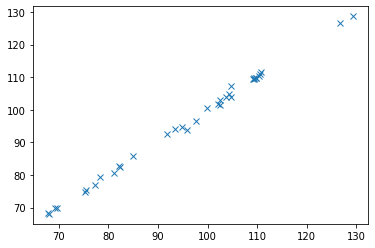

In [53]:
s = tf.reduce_mean(scaled,0)
plt.plot(s[:,0],s[:,1],'x')

# Result

This figure illustrates the calibration estimate for the five sensors. The first sensor is a reference sensor, so the mean and variance should be ignored from the plot (as they aren't really use). This is just $\times 1$. for the other plots the blue line is the mean and the green are the 95% CIs. The black line is the 'true' calibration.

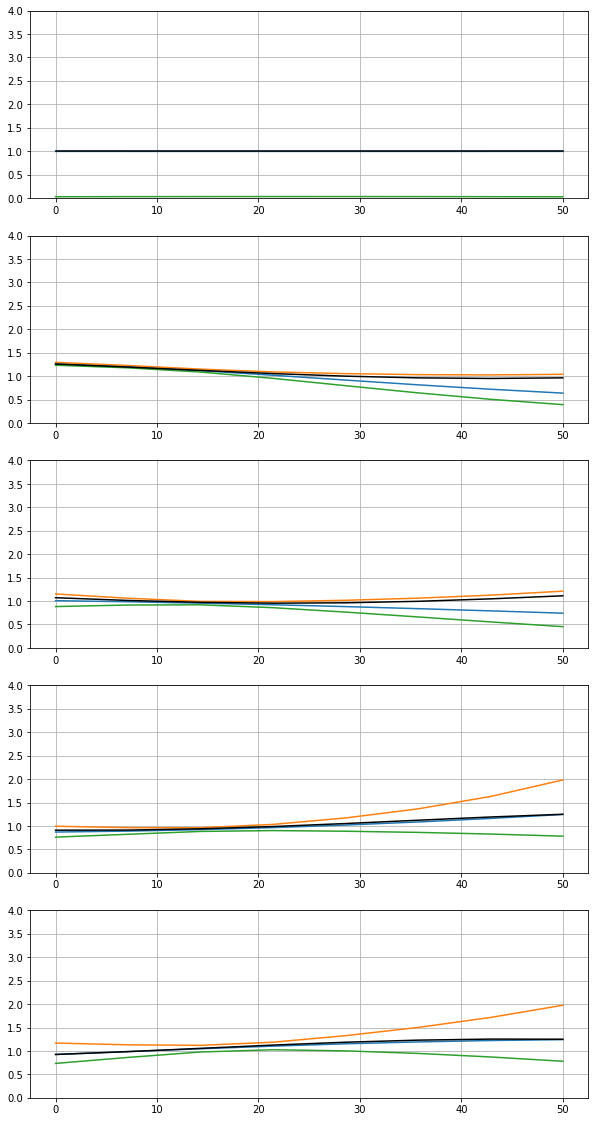

In [54]:
plt.figure(figsize=[10,20])
np.diag(getcov(scale))
for i,(z,d,v) in enumerate(zip(np.reshape(Z[:,0],[S,M]),np.reshape(mu.numpy(),[S,M]),np.reshape(np.diag(getcov(scale)),[S,M]))):
    plt.subplot(5,1,i+1)
    plt.plot(z,1/np.exp(d))
    plt.plot(z,1/np.exp(d-2*np.sqrt(v)))
    plt.plot(z,1/np.exp(d+2*np.sqrt(v)))
    plt.grid()
    plt.ylim([0,4])
    plt.plot(z,getsensorscaling(z,i),'k-')